# YouTube Comments Sentiment Analysis

This Jupyter Notebook analyzes sentiment in YouTube comments using the YouTube Data API, sentiment analysis with VADER, and visualizations.

## Table of Contents

- [Setup](#setup)
- [Importing Libraries](#Importing-Libraries)
- [Fetch YouTube Comments](#Fetch-YouTube-Comments)
- [Data Processing and Cleaning](#Data-Processing-and-Cleaning)
- [Sentiment Analysis with VADER](#Sentiment-Analysis-with-VADER)
- [Results Visualization](#Results-Visualization)
- [Conclusion](#Conclusion)

## Setup

### Installation of Required Libraries

```python
# Install necessary libraries
!pip install pandas numpy matplotlib google-api-python-client deep_translator nltk emoji wordcloud seaborn
```

## Importing Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from deep_translator import GoogleTranslator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

## Fetch YouTube Comments

### Steps to create a Project on Google Cloud Console:

- Go to the [Google Cloud Console](https://console.cloud.google.com).
- Click on the project drop-down menu at the top and select "New Project."
- Enter a name for your project and click "Create."

### Enable the YouTube Data API v3:

- In the Google Cloud Console, navigate to the "APIs & Services" > "Dashboard."
- Click on the "ENABLE APIS AND SERVICES" button.
- Search for "YouTube Data API v3" and select it.
- Click on the "Enable" button.

### Create Credentials (API Key):

- In the Google Cloud Console, navigate to the "APIs & Services" > "Credentials" page.
- Click on the "CREATE CREDENTIALS" button and select "API key."
- A new API key will be generated. You can restrict its usage if needed.

### Copy API Key:

- After creating the API key, copy the generated key. This key is what you will use in your get_video_comments function.

### Use API Key in Your Code:

Replace the api_key variable in your code with the actual API key you obtained.

### Video url

![image.png](image.png)

Replace the url with your desired youtube video's url and copy the url from address bar

### **NOTE : If the video has large amount of comments it will take long time**
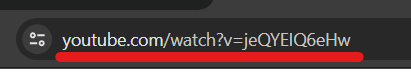

In [39]:
api_key = 'api_key' # replace api_key with your api key
video_url = 'https://www.youtube.com/watch?v=4MRZnWNjiXU' # change the youtube url that you want with

### Data Processing and Cleaning

In [21]:
# Function to fetch comments using YouTube API
def get_video_comments(api_key, video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)

    comments = []
    nextPageToken = None

    while True:
        try:
            response = youtube.commentThreads().list(
                part='snippet',
                videoId=video_id,
                textFormat='plainText',
                pageToken=nextPageToken
            ).execute()

            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)

            nextPageToken = response.get('nextPageToken')

            if not nextPageToken:
                break

        except HttpError as e:
            print(f"An HTTP error {e.resp.status} occurred: {e.content}")
            break

    return comments

In [22]:
# Function to fetch comments using YouTube API and save to CSV
def collect_and_save_data(api_key, video_url, csv_filename='youtube_comments_data.csv'):
    # Extract video ID from the URL
    video_id = video_url.split("=")[1]
    
    # Fetch comments using YouTube API
    comments = get_video_comments(api_key, video_id)

    # Save comments to a CSV file
    comments_df = pd.DataFrame({'Comment': comments})
    comments_df.to_csv(csv_filename, index=False)

In [23]:
# Function to translate text to English
def translate_to_english(text, target_language='en'):
    try:
        translated_text = GoogleTranslator(target_language=target_language).translate(text)
        return translated_text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

### Function to clean text (lowercasing, removing non-alphabetic characters, preserving emojis)

In [24]:
def clean_text(text):
    # Remove non-alphabetic characters
    # text = ''.join([char for char in text if char.isalpha() or char.isspace() or char in emoji.demojize(text)])

    # Handle emojis
    text = emoji.demojize(text)

    return text

In [25]:
# Function for data processing and cleaning with translation and emoji handling
def process_and_clean_data(csv_filename='youtube_comments_data.csv'):
    # Load data from CSV
    comments_df = pd.read_csv(csv_filename)

    # Remove duplicates and missing values
    comments_df = comments_df.drop_duplicates().dropna(subset=['Comment'])

    # Text cleaning: Convert to lowercase and remove non-alphabetic characters
    comments_df['Comment'] = comments_df['Comment'].str.lower()

    # Process translated comments
    comments_df['Cleaned_Comment'] = comments_df['Comment'].apply(lambda comment: clean_text(comment)).replace('[^a-zA-Z\s]', ' ', regex=True)
    
    # Translate non-English comments to English
    comments_df['Translated_Comment'] = comments_df['Cleaned_Comment'].apply(lambda comment: translate_to_english(comment, target_language='en'))

    return comments_df


### Sentiment Analysis with VADER

In [26]:
# Function for sentiment analysis using VADER
def analyze_sentiments_with_vader(df):
    # I have made this dict using ChatGPT
    new_words_youtube_extended_multi_language = {
        'amazing': 9,
        'excellent': 8,
        'superb': 8,
        'stellar': 8,
        'impressive': 7,
        'outstanding': 7,
        'terrific': 7,
        'brilliant': 7,
        'kudos': 7,
        'insightful': 6,
        'educational': 6,
        'helpful': 6,
        'thumbsup': 5,
        'thumbsdown': -5,
        'biased': -4,
        'spammy': -6,
        'toxic': -8,
        'abusive': -8,
        'unsubscribed': -7,
        'fantastique': 8,  # French for fantastic
        'extraordinaire': 8,  # French for extraordinary
        'increíble': 9,  # Spanish for incredible
        'asombroso': 9,  # Spanish for amazing
        'ausgezeichnet': 8,  # German for excellent
        'erstaunlich': 9,  # German for amazing
        'fenomenal': 8,  # Portuguese for phenomenal
        'incrível': 9,  # Portuguese for incredible
        'مذهل': 9,  # Arabic for amazing
        'رائع': 8,  # Arabic for fantastic
        'удивительный': 9,  # Russian for amazing
        'превосходный': 8,  # Russian for excellent
        'fenomenale': 8,  # Italian for phenomenal
        'incredibile': 9,  # Italian for incredible
        'ongelooflijk': 8,  # Dutch for unbelievable
        'geweldig': 8,  # Dutch for amazing
        'uimitor': 9,  # Romanian for amazing
        'excelent': 8,  # Romanian for excellent
        'ụtụtụ ọma': 9,  # Igbo for fantastic
        'ọma': 8,  # Igbo for good
        'अद्भुत': 9,  # Hindi for amazing
        'उत्कृष्ट': 8,  # Hindi for excellent
        'અદ્ભુત': 9,  # Gujarati for amazing
        'શાનદાર': 8,  # Gujarati for fantastic
    }

    # Instantiate the sentiment intensity analyzer
    vader = SentimentIntensityAnalyzer()

    # Update the lexicon with further extended custom words
    vader.lexicon.update(new_words_youtube_extended_multi_language)

    # Analyze sentiments
    df['Sentiment_Scores'] = df['Comment'].apply(lambda comment: vader.polarity_scores(comment))
    
    # Classify sentiment based on the compound score
    df['Sentiment_Label'] = df['Sentiment_Scores'].apply(lambda scores: 'Positive' if scores['compound'] >= 0.05 else ('Negative' if scores['compound'] <= -0.05 else 'Neutral'))

    return df

In [27]:
# Collect and save data to CSV
collect_and_save_data(api_key, video_url)

In [28]:
# Load data from CSV and perform data processing
processed_comments_df = process_and_clean_data()

In [29]:
# Display the processed DataFrame
processed_comments_df

,Comment,Cleaned_Comment,Translated_Comment
0,❤❤❤❤,red heart red heart red heart red heart,red heart red heart red heart red heart
1,💔💔,broken heart broken heart,broken heart broken heart
2,❤️my bubu. !!,red heart my bubu,red heart my bubu
3,heat touching mix song,heat touching mix song,heat touching mix song
4,wow songs,wow songs,wow songs
...,...,...,...
193,best song for ever,best song for ever,best song for ever
194,🎉,party popper,party popper
195,❤❤❤❤❤,red heart red heart red heart red heart r...,red heart red heart red heart red heart re...
196,0:02,,


In [30]:
comments_with_sentiments_df = analyze_sentiments_with_vader(processed_comments_df)
comments_with_sentiments_df

,Comment,Cleaned_Comment,Translated_Comment,Sentiment_Scores,Sentiment_Label
0,❤❤❤❤,red heart red heart red heart red heart,red heart red heart red heart red heart,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
1,💔💔,broken heart broken heart,broken heart broken heart,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
2,❤️my bubu. !!,red heart my bubu,red heart my bubu,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
3,heat touching mix song,heat touching mix song,heat touching mix song,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
4,wow songs,wow songs,wow songs,"{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'comp...",Positive
...,...,...,...,...,...
193,best song for ever,best song for ever,best song for ever,"{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'comp...",Positive
194,🎉,party popper,party popper,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",Neutral
195,❤❤❤❤❤,red heart red heart red heart red heart r...,red heart red heart red heart red heart re...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
196,0:02,,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral


### Results Visualization

C:\Users\Nakul\AppData\Local\Temp\ipykernel_4668\2348769283.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Label', data=comments_with_sentiments_df, palette='viridis')


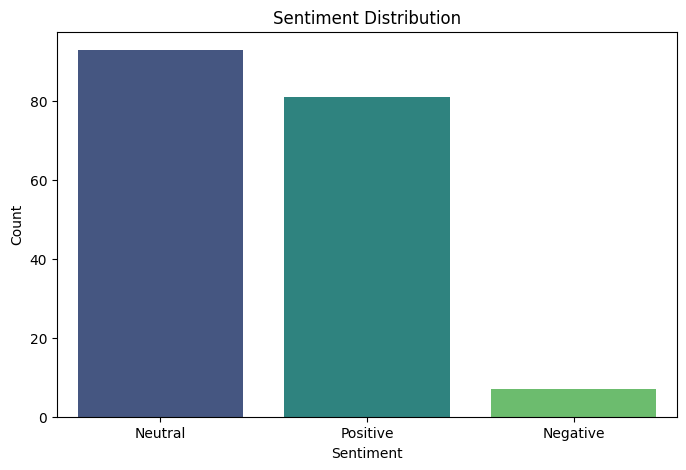

In [31]:
# Bar plot for sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Label', data=comments_with_sentiments_df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

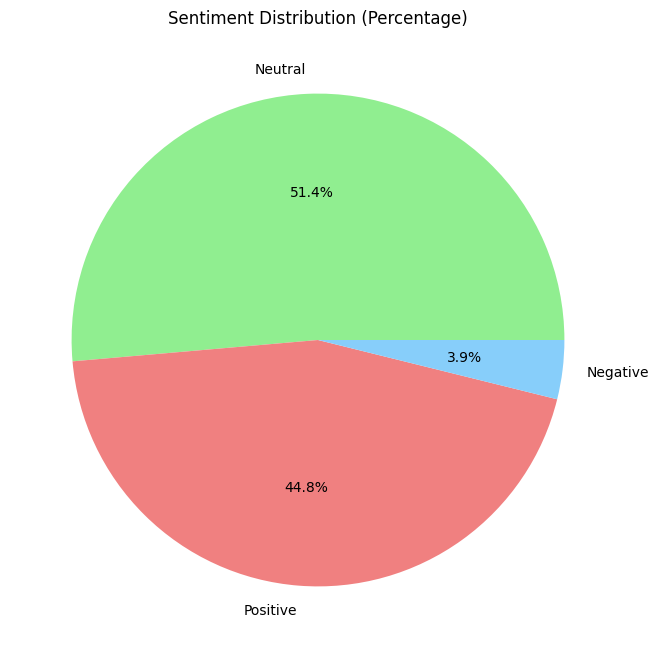

In [32]:
# Pie chart for sentiment distribution
sentiment_counts = comments_with_sentiments_df['Sentiment_Label'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Sentiment Distribution (Percentage)')
plt.show()

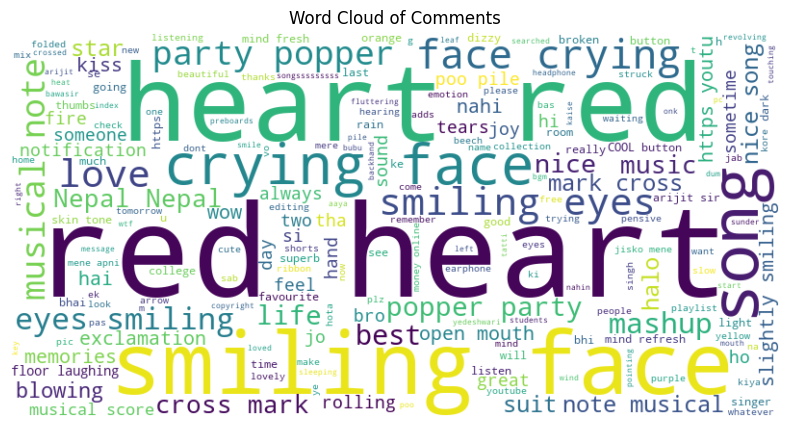

In [35]:
# word cloud, which shows the the word's size on the basis of its occurence 
all_comments = ' '.join(comments_with_sentiments_df['Cleaned_Comment'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

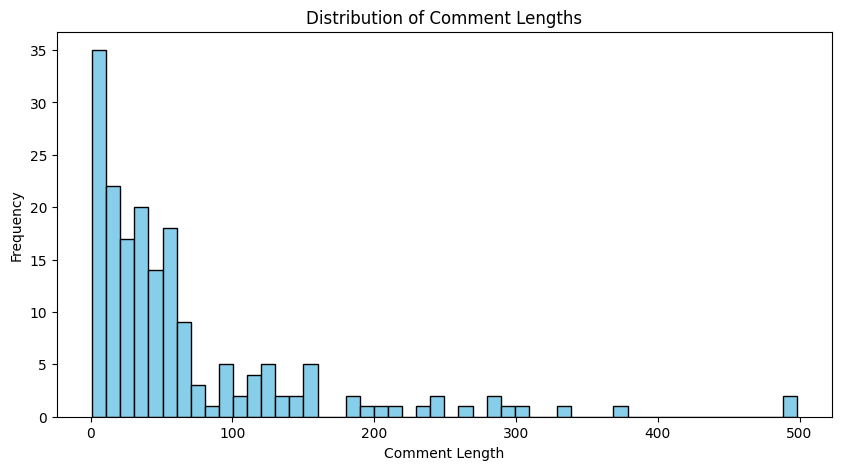

In [38]:
# Histogram of Comment Lengths, it shows how much long the comments are varying in the comment section
# To understand content complexity, longer comments may contain more complex ideas or arguments
# while shorter comments may express sentiments more straightforwardly. 
comments_with_sentiments_df['Comment_Length'] = comments_with_sentiments_df['Cleaned_Comment'].apply(len)

plt.figure(figsize=(10, 5))
plt.hist(comments_with_sentiments_df['Comment_Length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

### Conclusion

#### **YouTube Comments Sentiment Analysis Project**

This Jupyter Notebook conducts sentiment analysis on YouTube comments using a combination of the YouTube Data API, Natural Language Toolkit (NLTK), and various Python libraries. The project involves fetching comments from a specified YouTube video, processing and cleaning the data, and performing sentiment analysis using the VADER sentiment intensity analyzer.

#### **Project Workflow**

- **Fetching YouTube Comments**: The notebook begins by retrieving comments from a specified YouTube video using the YouTube Data API. The get_video_comments function interacts with the API, handling potential HTTP errors. If the video has large number of comments it may take some time to process.

- **Data Processing and Cleaning**: The comments data is then loaded into a Pandas DataFrame. Duplicate and missing values are removed, and text cleaning is performed, including lowercasing and removal of non-alphabetic characters. Emojis are preserved during this process.

- **Sentiment Analysis with VADER**: The sentiment intensity analyzer from NLTK's VADER module is employed to analyze the sentiment of each comment. The VADER lexicon is extended with custom words relevant to YouTube comments.

- **Results Visualization**: The notebook includes visualizations to represent the sentiment distribution, a pie chart for sentiment percentages, a word cloud to visualize common words, and a histogram of comment lengths.

**The video which I have used is a song video, so after analyzing, I got the insights that as this is a song video, so it has a lot of positive commments and some nuetral comments too, and a few negative comments.**

The sentiment analysis provides insights into the overall sentiment of YouTube comments, enabling a better understanding of audience reactions. This project serves as a valuable tool for content creators, marketers, and researchers seeking to gauge the sentiment of user engagement on YouTube videos. The combination of API interaction, natural language processing, and visualizations makes this notebook a versatile tool for sentiment analysis in the context of online video platforms.